# CEWA 568 Snow Hydrology - Spring 2023
## Lab 2-1

Written by Daniel Hogan - March 9, 2023

-----------------------------------------------------
## SNOTEL sites and data within the East River Valley
-----------------------------------------------------



This lab will introduce you to the NRCS SNow TELemetry (SNOTEL) sites (Butte and Schofield Pass) within the East River valley near Crested Butte, CO. We will first introduce the area that we will be studying by building a basic basemap of the Upper East River valley. Then, we will pull in the SNOTEL data for Butte and Schofield Pass. Once we have this data, we'll add in a few variables and show a plot of snow water equivalent (SWE) for your choice of SNOTEL site and water year. Let's get started!

-------------------------------------------
### Imports necessary for the notebook
A few packages may need to be installed including:
- contextily
- geopandas
- metloom
- xarray

To install, go to the command line and type: 

`conda install -c conda-forge contextily geopandas metloom xarray`

In [2]:
import xarray as xr # used for storing our data
import matplotlib.pyplot as plt
import contextily as cx # this is for plotting 
import geopandas as gpd # for location information of snotel sites
import numpy as np

import pandas as pd
from datetime import datetime
import datetime as dt
import xarray as xr
import requests


<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


-----------------------------------------
### Introduction to the Upper East River Valley

In [32]:
# Get SNTL data using an API built by Beau Uriona
AWDB_API_DOMAIN = "https://api.snowdata.info"
# Pull in metadata for all NRCS SNOTEL sites
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Read the file in and take a look (rename some columns to make them more informative)
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl.head()

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
0,22G06S,2000-09-01,Klamath,2100-01-01,US,035,41,180102030101,18010201,Annie Springs,ANSO3,-8.0,NaN,1000:OR:SNTL,POINT Z (-122.16518 42.87007 6010.00000)
1,33J01S,1966-10-01,Juneau,2100-01-01,US,110,02,190102060505,19010201,Long Lake,LLKA2,-9.0,NaN,1001:AK:SNTL,POINT Z (-133.83217 58.18600 850.00000)
2,51K14S,1985-10-01,Kenai Peninsula,2100-01-01,US,122,02,190203010806,19020301,Mcneil Canyon,MCNA2,-9.0,NaN,1003:AK:SNTL,POINT Z (-151.25133 59.74433 1320.00000)
3,05M17S,2000-08-16,Costilla,2100-01-01,US,023,08,130100020604,13010002,Ute Creek,UTCC2,-8.0,NaN,1005:CO:SNTL,POINT Z (-105.37322 37.61480 10734.00000)
4,16J01S,2000-10-01,Lander,2100-01-01,US,015,32,160401070903,16040107,Lewis Peak,LWPN2,-8.0,NaN,1006:NV:SNTL,POINT Z (-116.86470 40.35720 7370.00000)


Now, let's filter this dataset to just the two stations within the East River basin - Butte and Schofield Pass

In [176]:
# Build a dictionary with the names and station triplet ids
east_river_sntl_dict = {'Butte':'380:CO:SNTL',
                        'Schofield Pass': '737:CO:SNTL'}
# Let's quickly transform the data into the location UTM 13N Coordinate system
east_river_utm_crs = '32613'
gdf_sntl = gdf_sntl.to_crs(east_river_utm_crs)

# Finally lets filter the to our SNOTEL sites
east_sntl_gdf = gdf_sntl[gdf_sntl['site_name'].isin(list(east_river_sntl_dict.keys()))]

# Adding a point for our kettle ponds site location
kp_loc = gpd.GeoSeries(gpd.points_from_xy(x=[-106.97298], y=[38.94182], crs='4326')).to_crs(east_sntl_gdf.crs)

---------------------------------------
### Visualize the valley with a Basemap

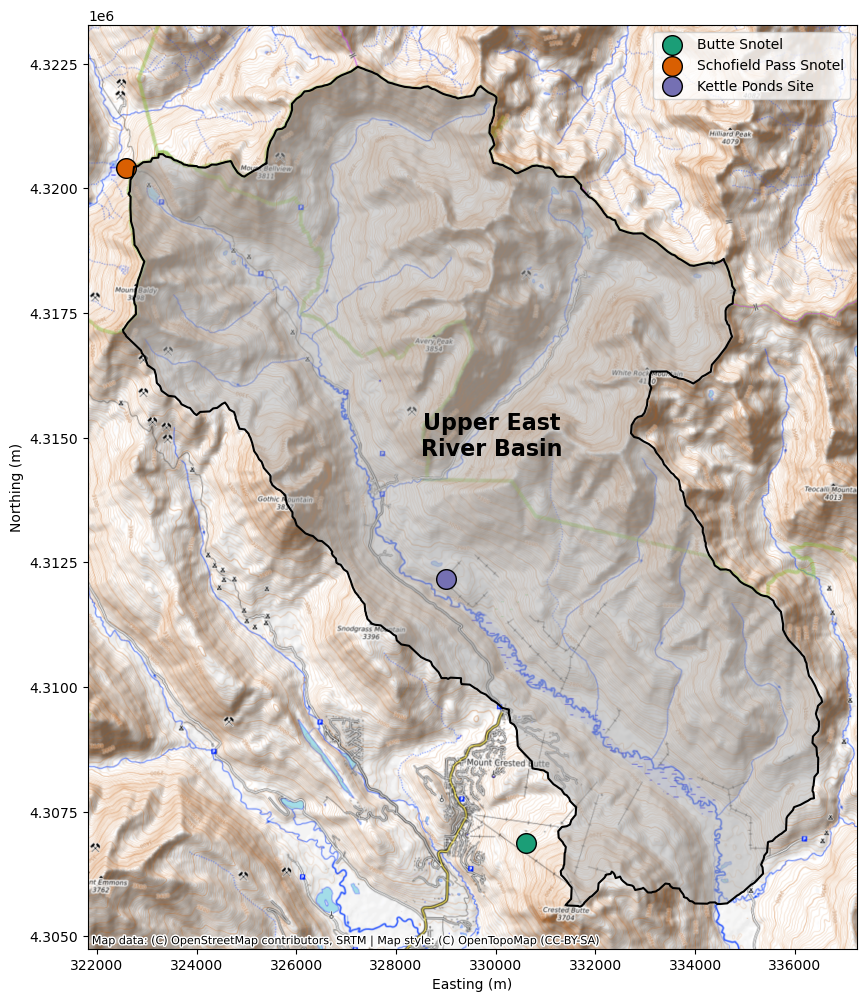

In [194]:
# Read in the Upper East River file
upper_east_river_polygon = gpd.read_file('./east_polygon.json')

cb_colors = ['#1b9e77','#d95f02','#7570b3']

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,12))
# Plot Upper East River polygon
upper_east_river_polygon.plot(ax=ax, 
                              color='darkgrey',
                              alpha=0.5,
                              zorder=1)
upper_east_river_polygon.boundary.plot(ax=ax, 
                              color='k')
# Plot SNTL locations
east_sntl_gdf[east_sntl_gdf['site_name']=='Butte'].plot(color=cb_colors[0],
                                                        ec='k',
                                                        markersize= 200, 
                                                        ax=ax, 
                                                        label='Butte Snotel')
east_sntl_gdf[east_sntl_gdf['site_name']=='Schofield Pass'].plot(color=cb_colors[1],
                                                                 ec='k',
                                                                 markersize= 200, 
                                                                 ax=ax, 
                                                                 label='Schofield Pass Snotel')

# Plot Kettle Ponds locations
kp_loc.plot(color=cb_colors[2],
            ec='k',
             markersize=200, 
             ax=ax, 
             label='Kettle Ponds Site')
# Label the Upper East River Basin
ax.text(upper_east_river_polygon.centroid.x, upper_east_river_polygon.centroid.y,
        "Upper East\nRiver Basin",
        fontsize=16, 
        fontweight='bold',
        color='k',
        horizontalalignment='center')

# If downloading contextily is causing issues, comment the below line out
cx.add_basemap(ax=ax, crs=upper_east_river_polygon.crs.to_string(),source=cx.providers.OpenTopoMap);
# Add legend
ax.legend();
ax.set_xlabel('Easting (m)');
ax.set_ylabel('Northing (m)');

---------------------------------------------------------------
### Pull in daily SNOTEL SWE, snow depth, and average temperature data
Read more about the NRCS SNOTEL network here: 

https://www.nrcs.usda.gov/wps/portal/wcc/home/aboutUs/monitoringPrograms/automatedSnowMonitoring/#:~:text=Snow%20Telemetry%20(SNOTEL)%20Network,temperature%2C%20and%20other%20climatic%20conditions.

In [49]:
site_ids = list(east_river_sntl_dict.values())

['380:CO:SNTL', '737:CO:SNTL']

This function will pull in daily SWE (WTEQ), temperature (TAVG) and snow depth (SNWD) for the specified time. It will default to pulling in the full record (going up to yesterday's date). The output will be an xarray dataset with SNOTEL locations and time as dimensions. You can transform this to a pandas dataframe using the `to_dataframe()` method.

In [50]:
# API Domain name
API_DOMAIN = "https://api.snowdata.info/"
def get_awdb_data(
    site_ids,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    server=API_DOMAIN,
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

# Grab dataframes that we want, can add other desired inputs to the function if a shorter time period is desired
sntl_dfs = get_awdb_data(site_ids=site_ids)

# Make the index a datetime
for i,df in enumerate(sntl_dfs):
    df.index = pd.to_datetime(df.index)
    sntl_dfs[i] = df

# create a dictionary for conversion to xarray
sntl_df_dict = {
    site_ids[0]:pd.concat(sntl_dfs[0:3], axis=1).sort_index().to_xarray(),
    site_ids[1]:pd.concat(sntl_dfs[3:6], axis=1).sort_index().to_xarray()
    }



getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-03-08
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-03-08
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-03-08
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-03-08
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-03-08
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-03-08


--------------------------------------
### Another way to get SNOTEL data using the metloom package
Check out the documentation here! https://metloom.readthedocs.io/en/latest/

This is a bit simpler to use and nice when asking for data from one site, but a bit slower to pull in data

In [4]:
from metloom.pointdata import SnotelPointData

start_date = dt.datetime(1980,10,1)
end_date = dt.datetime.today()-dt.timedelta(days=1)
snotel_point = SnotelPointData("380:CO:SNTL", "Butte")
butte_df = snotel_point.get_daily_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.SWE]
)

snotel_point = SnotelPointData("737:CO:SNTL", "Schofield Pass")
schofield_df = snotel_point.get_daily_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.SWE]
)

In [6]:
# Take a look at the dataframe for Butte
butte_df.head()

,,geometry,SWE,SWE_units,datasource
datetime,site,,,,
1980-10-01 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,NRCS
1980-10-02 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,NRCS
1980-10-03 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,NRCS
1980-10-04 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,NRCS
1980-10-05 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,NRCS


-----------------------------
### From here, we will use the xarray dataset
But feel free to rewrite code to your liking using the dataframes produced above

We'll convert our dataframes to xarray since we will be using xarray for other SOS and atmospheric science data, which use netcdfs (read more about this here: https://docs.xarray.dev/en/stable/)
Think of xarray as a bunch of pandas dataframes stacked on top of eachother into another dimension (this may not help, but that helped me think of how it works)

In [152]:
# convert to xarray
sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
# Add water year variable
sntl_ds = sntl_ds.assign_coords({'WY':sntl_ds.Date.dt.year.where(sntl_ds.Date.dt.month < 10, sntl_ds.Date.dt.year + 1)})

Let's take a quick look at what this looks like:
- We have two dimensions (labeled on top) which we can filter on, Date and Location
- Note: all dimensions are "coordinates", but not all coordinates are dimensions, for example, the WY coordinate depends on the Date dimension, so we cannot filter on it.
- We have 3 variables, the same ones we pulled above: TAVG, SNWD and WTEQ. You can click around to see the values and attributes (the file looking icon), which will have the units that we declared when we pulled the data.

In [61]:
sntl_ds

<xarray.Dataset>
Dimensions:   (Date: 15499, Location: 2)
Coordinates:
  * Date      (Date) datetime64[ns] 1980-10-01 1980-10-02 ... 2023-03-08
  * Location  (Location) object '380:CO:SNTL' '737:CO:SNTL'
    WY        (Date) int64 1981 1981 1981 1981 1981 ... 2023 2023 2023 2023 2023
Data variables:
    TAVG      (Location, Date) float64 nan nan nan nan ... -5.6 -2.5 -3.6 -3.4
    SNWD      (Location, Date) float64 nan nan nan nan ... 266.7 261.6 256.5
    WTEQ      (Location, Date) float64 0.0 0.0 0.0 0.0 ... 87.38 87.38 87.38

We'll also apply some filters so filter out crazy data points

- We're assuming that more than 50 inches of snow does not fall in a day here (hint: it does not, check out record daily snowfalls with this link at different locations: https://www.wunderground.com/cat6/Summary-US-State-Historical-Snowfall-Extremes)
- We're also assuming that temperatures are between -50 F and 110 F and daily difference is less than 50 degrees. The coldest temperature recorded at a nearby weather station since 1977 is -40F (which is also -40C!)


In [153]:
# Apply data filters for bad data
# We're assuming that more than 50 inches of snow does not fall in a day here (hint: it does not, check out record daily snowfalls with this link at different locations:)
sntl_ds['SNWD'] = sntl_ds.where(abs(sntl_ds['SNWD'].diff(dim='Date'))<50)['SNWD']

# We're also assuming that temperatures are between -50 F and 110 F and daily difference is less than 50 degrees. The coldest temeprature recorded at a
# nearby weather station since 1977 is -40F (which is also -40C!)

sntl_ds['TAVG'] = sntl_ds.where((abs(sntl_ds['TAVG'].diff(dim='Date'))<50) & 
                                    (sntl_ds['TAVG']>-50) &
                                    ((sntl_ds['TAVG']<110)))['TAVG']

Let's convert units from imperial to metric units and add them as an attribute

In [154]:
# Unit conversions to centimeters
sntl_ds['SNWD'] = sntl_ds['SNWD']*2.54
sntl_ds['SNWD'] = sntl_ds['SNWD'].assign_attrs({'units':'cm'})

sntl_ds['WTEQ'] = sntl_ds['WTEQ']*2.54
sntl_ds['WTEQ']  = sntl_ds['WTEQ'].assign_attrs({'units':'cm'})

# Unit conversion to degrees Celsius
sntl_ds['TAVG'] =  (sntl_ds['TAVG']-32) * 5/9
sntl_ds['TAVG'] = sntl_ds['TAVG'].assign_attrs({'units':'degC'})

### Filter and plot snow water equivalent for a water year for your station of choice
- Decide what site you want to look at: Butte or Schofield Pass
- Change the WY variable to see what it shows (must be a greater water year than the minimum water year printed below)

In [167]:
### USER DECIDES WHICH SITE
site = east_river_sntl_dict['Butte']
title = list(east_river_sntl_dict.keys())[list(east_river_sntl_dict.values()).index(site)]

print(f'Minimum water year is {sntl_ds.sel(Location=site).WY.to_pandas().min()}')

Minimum water year is 1981


(0.0, 72.31)

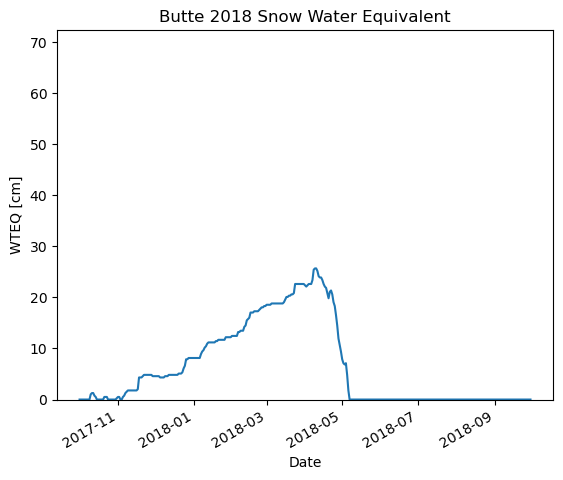

In [164]:
### USER DECIDES WHICH WATER YEAR (needs to be between the start and end data)
WY = 2018

# Filter to our location and our water year and plot
site_wy_swe = sntl_ds.sel(Location=site).where(sntl_ds.WY==WY)['WTEQ']

fig, ax = plt.subplots()
site_wy_swe.plot(ax=ax)
ax.set_title(f'{title} {WY} Snow Water Equivalent')
ax.set_ylim(0,sntl_ds.sel(Location=site)['WTEQ'].max()+5)



Let's see how this year stacks up with the median snow year and plot that too:

In [162]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
# Create an empty array with the same length as the day of water year
dowy = np.zeros(len(sntl_ds.Date.values))
for i,date in enumerate(sntl_ds.Date.values):
    dowy[i] = date2DOWY(date)
# Add this to our dataset
sntl_ds = sntl_ds.assign_coords({'dowy':('Date',dowy)})

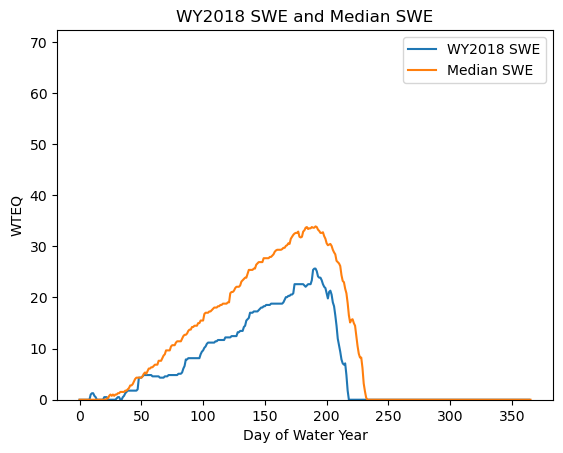

In [165]:
fig, ax = plt.subplots()

ax.plot(sntl_ds.sel(Location=site).where(sntl_ds.WY==WY).dowy,
        sntl_ds.sel(Location=site).where(sntl_ds.WY==WY)['WTEQ'],
        label=f'WY{WY} SWE')

sntl_ds.sel(Location=site).groupby(sntl_ds.dowy).median()['WTEQ'].plot(ax=ax,
                                                                       label='Median SWE')
ax.set_xlabel('Day of Water Year')
ax.set_title(f'WY{WY} SWE and Median SWE')
ax.set_ylim(0,sntl_ds.sel(Location=site)['WTEQ'].max()+5)
ax.legend()